In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import *

def test_points(n_in, n_out):
    a = (np.random.rand(n_in) - 0.5) * 10
    b = np.vstack((a, a * 0.5 + np.random.randn(n_in) * 0.25))
    points = np.hstack((b, 2 * np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T ## shuffle list

# Ex 7.1-7.6

In [8]:
class RANSAC_Lines():
    def __init__(self):
        self.a = 0  ## No use
        
    def Generate_points(self, n_in, n_out):
        a = (np.random.rand(n_in) - 0.5) * 10
        b = np.vstack((a, a * 0.5 + np.random.randn(n_in) * 0.25))
        points = np.hstack((b, 2 * np.random.randn(2, n_out)))
        return np.random.permutation(points.T).T ## shuffle list
    
    def Estimate_line(self, point1, point2):
        ### sympy use list not ndarray, cannot use list and ndarray togather
        
        point1_list = []
        point2_list = []
        for i, j in zip(point1, point2):
            point1_list.append(list(i)[0])
            point2_list.append(list(j)[0])
        
        x = symbols('x')
        y = symbols('y')
        r = symbols('r')
    
        f1 = point1_list[0]*x + point1_list[1]*y + point1_list[2]*r
        f2 = point2_list[0]*x + point2_list[1]*y + point2_list[2]*r
        f3 = x**2 + y**2 - 1
    
        line_param = solve([f1,f2,f3], [x, y, r])
        
        try:
            line_param = np.array(line_param, dtype = 'float32')
        except:
            print(line_param)
        
        for i in line_param:
            if i[2] >= 0: 
                if math.atan2(i[1], i[0]) >=0 and math.atan2(i[1], i[0]) <= 2*math.pi:
                    final_line = i
                elif math.atan2(i[1], i[0]) < 0 and math.atan2(i[1], i[0]) + 2*(math.pi) < 2 * math.pi:
                    final_line = i
            
        return np.asarray(final_line).reshape(-1,1).astype('float32')
    
    def Get_consensus(self, line, points, threshold):
        consensus = 0
        Points = []
        for point in points.T:
            distance = np.abs(line.T @ point.T)
            if distance <= threshold:
                consensus = consensus + 1
                Points.append(point)
        return consensus, Points
    
    def Random_get2points(self, points):
        point_index = []
        for i in range(points.shape[1]):
            point_index.append(i)
        ### Incase the same point is selected 
        point1_index = point_index[np.random.randint(len(point_index))]
        point_index.remove(point1_index)
        
        point2_index = point_index[np.random.randint(len(point_index))]
        
        point1 = points[:, point1_index]
        point2 = points[:, point2_index]
        return point1.reshape(3,1), point2.reshape(3,1)
    
    
    def forward(self, n_in, n_out, iterations, thresh):
        points = self.Generate_points(n_in, n_out)
        points_H = np.vstack((points, np.ones((1, points.shape[1])))) ## homogenous coordinates
        Max_consensus = 0
        count = 0
        for i in range(iterations):
            point1, point2 = self.Random_get2points(points_H)
            line = self.Estimate_line(point1, point2)
            consensus, inlier_points = self.Get_consensus(line, points_H, thresh)
            if consensus > Max_consensus:
                Max_consensus = consensus
                finalLine = line
                final_inlierPoints = inlier_points
            count = count + 1
        print('Max_consensus:', Max_consensus)
        return points, finalLine, final_inlierPoints

Max_consensus: 20


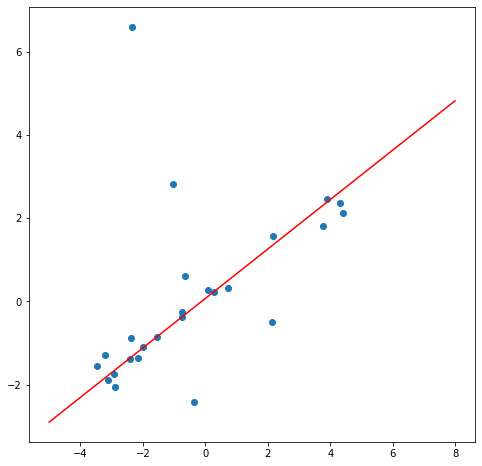

In [9]:
estimate_line = RANSAC_Lines()
points, finalLine, final_inlierPoints = estimate_line.forward(20, 5, 400, 0.5)

left_x = -5
left_y = -(finalLine[2] + finalLine[0]*left_x)/finalLine[1]

right_x = 8
right_y = -(finalLine[2] + finalLine[0]*right_x)/finalLine[1]

plt.figure(figsize=(8,8))
plt.scatter(points[0], points[1])
plt.plot([left_x, right_x], [left_y, right_y], 'r')

# Ex 7.7

In [14]:
def pca_line(points):
    d = np.cov(points)[:,0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l @ points.mean(1)))
    return l

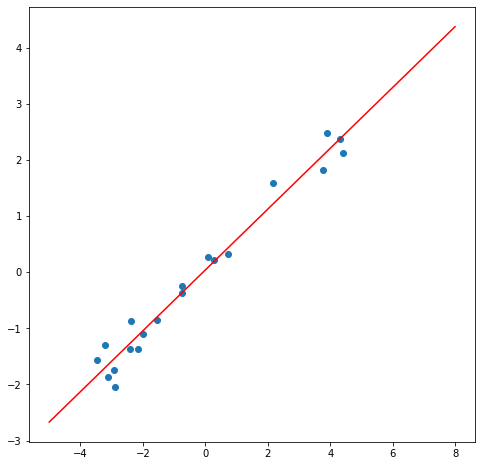

In [15]:
points = (np.array(final_inlierPoints).T)[:2]
l = pca_line(points)

left_x = -5
left_y = -(l[2] + l[0]*left_x)/l[1]

right_x = 8
right_y = -(l[2] + l[0]*right_x)/l[1]

plt.figure(figsize=(8,8))
plt.scatter(points[0], points[1])
plt.plot([left_x, right_x], [left_y, right_y], 'r')

# Ex 7.8

In [51]:
class RANSAC_Lines_Criteria():
    def __init__(self):
        self.p = 0.99  
        self.n = 2
        
        
    def Generate_points(self, n_in, n_out):
        a = (np.random.rand(n_in) - 0.5) * 10
        b = np.vstack((a, a * 0.5 + np.random.randn(n_in) * 0.25))
        points = np.hstack((b, 2 * np.random.randn(2, n_out)))
        return np.random.permutation(points.T).T ## shuffle list
    
    def Estimate_line(self, point1, point2):
        ### sympy use list not ndarray, cannot use list and ndarray togather
        
        point1_list = []
        point2_list = []
        for i, j in zip(point1, point2):
            point1_list.append(list(i)[0])
            point2_list.append(list(j)[0])
        
        x = symbols('x')
        y = symbols('y')
        r = symbols('r')
    
        f1 = point1_list[0]*x + point1_list[1]*y + point1_list[2]*r
        f2 = point2_list[0]*x + point2_list[1]*y + point2_list[2]*r
        f3 = x**2 + y**2 - 1
    
        line_param = solve([f1,f2,f3], [x, y, r])
        
        try:
            line_param = np.array(line_param, dtype = 'float32')
        except:
            print(line_param)
        
        for i in line_param:
            if i[2] >= 0: 
                if math.atan2(i[1], i[0]) >=0 and math.atan2(i[1], i[0]) <= 2*math.pi:
                    final_line = i
                elif math.atan2(i[1], i[0]) < 0 and math.atan2(i[1], i[0]) + 2*(math.pi) < 2 * math.pi:
                    final_line = i
            
        return np.asarray(final_line).reshape(-1,1).astype('float32')
    
    def Get_consensus(self, line, points, threshold):
        consensus = 0
        Points = []
        for point in points.T:
            distance = np.abs(line.T @ point.T)
            if distance <= threshold:
                consensus = consensus + 1
                Points.append(point)
        return consensus, Points
    
    def Random_get2points(self, points):
        point_index = []
        for i in range(points.shape[1]):
            point_index.append(i)
        ### Incase the same point is selected 
        point1_index = point_index[np.random.randint(len(point_index))]
        point_index.remove(point1_index)
        
        point2_index = point_index[np.random.randint(len(point_index))]
        
        point1 = points[:, point1_index]
        point2 = points[:, point2_index]
        return point1.reshape(3,1), point2.reshape(3,1)
    
    
    def forward(self, n_in, n_out, iterations, thresh):
        points = self.Generate_points(n_in, n_out)
        points_H = np.vstack((points, np.ones((1, points.shape[1])))) ## homogenous coordinates
        Max_consensus = 0
        count = 0
        for i in range(iterations):
            point1, point2 = self.Random_get2points(points_H)
            line = self.Estimate_line(point1, point2)
            consensus, inlier_Points = self.Get_consensus(line, points_H, thresh)
            if consensus > Max_consensus:
                Max_consensus = consensus
                finalLine = line
                final_inlierPoints = inlier_Points
            
            count = count + 1
            ## Set Criteria
            eta = 1 - Max_consensus/(n_in + n_out)
            if eta == 1:
                eta = n_out/(n_in + n_out)   ## Incase the denominator of N is 0
            N = int(math.log(1-self.p)/math.log((1 - math.pow((1 - eta), self.n))))
            if N <= count:
                break
        print(' Real Points:', n_in)
        print(' Noise Points:', n_out)
        print(' Max Consensus:', Max_consensus)
        return points, finalLine, final_inlierPoints,count

In [52]:
def pca_line(points):
    d = np.cov(points)[:,0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l @ points.mean(1)))
    return l

 Real Points: 100
 Noise Points: 40
 Max Consensus: 99
 Set Iterations:100
 Termiante Iterations:6


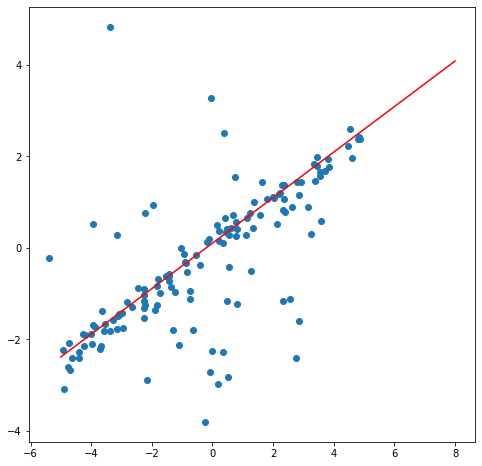

In [54]:
estimate_line = RANSAC_Lines_Criteria()
points, finalLine, final_inlierPoints,count = estimate_line.forward(100, 40, 100, 0.4)

print(' Set Iterations:{}\n Termiante Iterations:{}'.format(100, count))

left_x = -5
left_y = -(finalLine[2] + finalLine[0]*left_x)/finalLine[1]

right_x = 8
right_y = -(finalLine[2] + finalLine[0]*right_x)/finalLine[1]

plt.figure(figsize=(8,8))
plt.scatter(points[0], points[1])
plt.plot([left_x, right_x], [left_y, right_y], 'r')

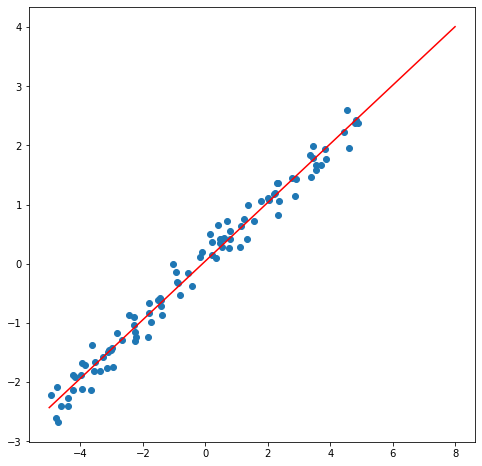

In [55]:
points = (np.array(final_inlierPoints).T)[:2]
l = pca_line(points)

left_x = -5
left_y = -(l[2] + l[0]*left_x)/l[1]

right_x = 8
right_y = -(l[2] + l[0]*right_x)/l[1]

plt.figure(figsize=(8,8))
plt.scatter(points[0], points[1])
plt.plot([left_x, right_x], [left_y, right_y], 'r')